# Spatial Communication

Spatial communication is a point of interest for us for the Spatial Transcriptomics Society, and we would like to find the conduction process of spatial communication.

Here, we introduce two method integrated in omicverse named `COMMOT` and `flowsig`.

We made three improvements in integrating the `COMMOT` and `flowsig` algorithm in OmicVerse:

- We reduced the installation conflict of `COMMOT` and `flowsig`, user only need to update OmicVerse to the latest version.
- We optimized the visualization of `COMMOT` and `flowsig` and unified the data preprocessing process so that users don't need to struggle with different data processing flows.
- We have fixed some bugs that could occur during function.

If you found this tutorial helpful, please cite `COMMOT`, `flowsig` and OmicVerse:

- Cang, Z., Zhao, Y., Almet, A.A. et al. Screening cell–cell communication in spatial transcriptomics via collective optimal transport. Nat Methods 20, 218–228 (2023). https://doi.org/10.1038/s41592-022-01728-4
- Almet, A.A., Tsai, YC., Watanabe, M. et al. Inferring pattern-driving intercellular flows from single-cell and spatial transcriptomics. Nat Methods (2024). https://doi.org/10.1038/s41592-024-02380-w

In [1]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 00:13:02 CST


## Preprocess data

Here we present our re-analysis of 151676 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

This tutorial demonstrates how to identify spatial domains on 10x Visium data using STAGATE. The processed data are available at https://github.com/LieberInstitute/spatialLIBD. We downloaded the manual annotation from the spatialLIBD package and provided at https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [2]:
adata = sc.read_visium(path='data', count_file='151676_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading data/151676_filtered_feature_bc_matrix.h5
 (0:00:00)


<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    We introduced the spatial special svg calculation module prost in omicverse versions greater than `1.6.0` to replace scanpy's HVGs, if you want to use scanpy's HVGs you can set mode=`scanpy` in `ov.space.svg` or use the following code.
  </p>
</div>

```python
#adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,target_sum=1e4)
#adata.raw = adata
#adata = adata[:, adata.var.highly_variable_features]
```

In [3]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:,adata.var['total_counts']>100]
adata=ov.space.svg(adata,mode='prost',n_svgs=3000,target_sum=1e4,platform="visium",)
adata


Filtering genes ...

Calculating image index 1D:

Normalize each geneing...

Gaussian filtering...


100%|██████████| 5779/5779 [00:19<00:00, 296.45it/s]



Binary segmentation for each gene:


100%|██████████| 5779/5779 [00:21<00:00, 267.77it/s]



Spliting subregions for each gene:


100%|██████████| 5779/5779 [00:21<00:00, 263.34it/s]



Computing PROST Index for each gene:


100%|██████████| 5779/5779 [00:05<00:00, 1131.14it/s]


PROST Index calculation completed !!
PI calculation is done!
normalizing counts per cell
    finished (0:00:00)


normalization and log1p are done!


AnnData object with n_obs × n_vars = 3460 × 5779
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'space_variable_features', 'highly_variable'
    uns: 'spatial', 'grid_size', 'locates', 'nor_counts', 'gau_fea', 'binary_image', 'subregions', 'del_index', 'log1p', 'REFERENCE_MANU'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
adata.write('data/cluster_svg.h5ad',compression='gzip')

In [5]:
#adata=ov.read('data/cluster_svg.h5ad',compression='gzip')

## Communication Analysis with COMMOT

### Spatial communication inference

We will use the CellChatDB ligand-receptor database here. Only the secreted signaling LR pairs will be used.

Jin, Suoqin, et al. “Inference and analysis of cell-cell communication using CellChat.” Nature communications 12.1 (2021): 1-20.

In [6]:
df_cellchat = ov.external.commot.pp.ligand_receptor_database(species='human', 
                                                             signaling_type='Secreted Signaling', 
                                                             database='CellChat')
print(df_cellchat.shape)

(1199, 4)


We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.

In [7]:
df_cellchat_filtered = ov.external.commot.pp.filter_lr_database(df_cellchat, 
                                                                adata, 
                                                                min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(19, 4)


Now perform spatial communication inference for these 250 ligand-receptor pairs with a spatial distance limit of 500. CellChat database considers heteromeric units. The signaling results are stored as spot-by-spot matrices in the obsp slots. For example, the score for spot i signaling to spot j through the LR pair can be retrieved from `adata.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]`.

In [8]:
ov.external.commot.tl.spatial_communication(adata,
                            database_name='cellchat', 
                            df_ligrec=df_cellchat_filtered, 
                            dis_thr=500, heteromeric=True, 
                            pathway_sum=True)


100%|██████████| 19/19 [00:00<00:00, 94.40it/s]


...start to solve the collective optimal transport problem


Processing source species: 100%|██████████| 12/12 [00:00<00:00, 191.61it/s]


...start to solve the row-wise optimal transport problem


Processing source species: 100%|██████████| 12/12 [01:20<00:00,  6.71s/it]


...start to solve the column-wise optimal transport problem


Processing destination species: 100%|██████████| 19/19 [02:15<00:00,  7.12s/it]


...start to solve the block-wise optimal transport problem


Processing source species: 100%|██████████| 12/12 [02:21<00:00, 11.78s/it]


(Optional) We read the ground truth area of our spatial data

This step is not mandatory to run, in the tutorial, it's just to demonstrate the accuracy of our clustering effect, and in your own tasks, there is often no Ground_truth

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    You can also use Celltype and other annotated results in adata.obs, here is just a randomly selected type, there is no particular significance, in order to facilitate the visualization and study the signal
  </p>
</div>

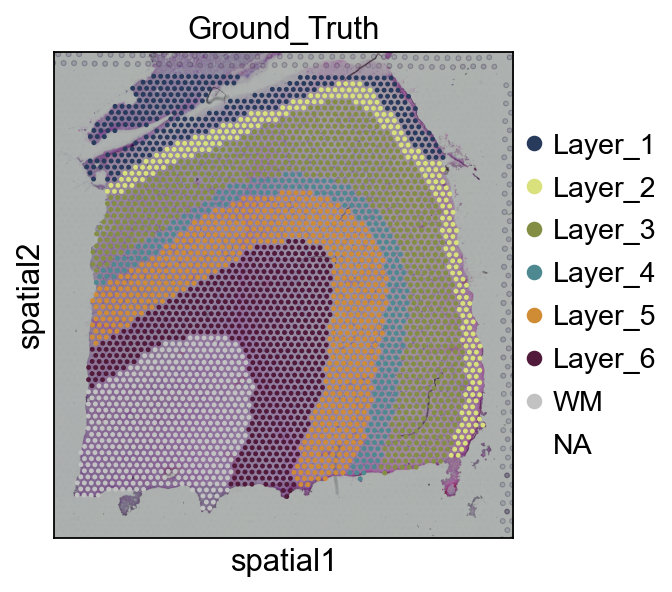

In [9]:
# read the annotation
import pandas as pd
import os
Ann_df = pd.read_csv(os.path.join('data', '151676_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground_Truth']
adata.obs['Ground_Truth'] = Ann_df.loc[adata.obs_names, 'Ground_Truth']
Layer_color=['#283b5c', '#d8e17b', '#838e44', '#4e8991', '#d08c35', '#511a3a',
       '#c2c2c2', '#dfc648']
sc.pl.spatial(adata, img_key="hires", color=["Ground_Truth"],palette=Layer_color)

### Visualize the communication signal in spatial space

Determine the spatial direction of a signaling pathway, for example, the FGF pathway. The interpolated signaling directions for where the signals are sent by the spots and where the signals received by the spots are from are stored in `adata.obsm['commot_sender_vf-cellchat-FGF']` and `adata.obsm['commot_receiver_vf-cellchat-FGF']`, respectively.

Taken together, our findings indicate that FGF signaling is crucial for cortical folding in gyrencephalic mammals and is a pivotal upstream regulator of the production of OSVZ progenitors. FGF signaling is the first signaling pathway found to regulate cortical folding.

In [10]:
ct_color_dict=dict(zip(adata.obs['Ground_Truth'].cat.categories,
                      adata.uns['Ground_Truth_colors']))

In [11]:
adata.uns['commot-cellchat-info']['df_ligrec'].head()

,ligand,receptor,pathway
0,NRG3,ERBB4,NRG
1,FGF1,FGFR2,FGF
2,FGF1,FGFR3,FGF
3,PDGFA,PDGFRA,PDGF
4,SPP1,ITGAV_ITGB1,SPP1


Text(0.5, 1.0, 'Pathway:FGF')

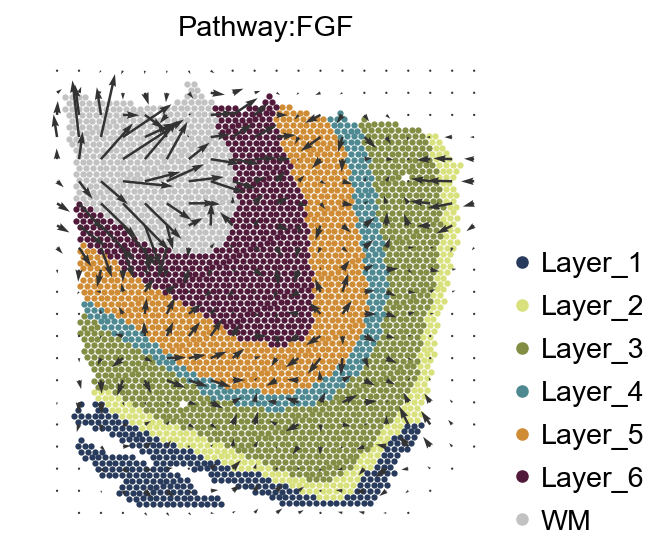

In [12]:
import matplotlib.pyplot as plt
scale=0.000008
k=5
goal_pathway='FGF'
ov.external.commot.tl.communication_direction(adata, database_name='cellchat', pathway_name=goal_pathway, k=k)
ov.external.commot.pl.plot_cell_communication(adata, database_name='cellchat', 
                                              pathway_name='FGF', plot_method='grid', 
                                              background_legend=True,
                                              scale=scale, ndsize=8, grid_density=0.4, 
                                              summary='sender', background='cluster', 
                                              clustering='Ground_Truth', 
                                              cluster_cmap=ct_color_dict,
                                              cmap='Alphabet',
                                              normalize_v = True, normalize_v_quantile=0.995)
plt.title(f'Pathway:{goal_pathway}',fontsize=13)
#plt.savefig('figures/TLE/TLE_cellchat_all_FGF.png',dpi=300,bbox_inches='tight')
#fig.savefig('pdf/TLE/control_cellchat_all_FGF.pdf',dpi=300,bbox_inches='tight')


In [13]:
adata.write('data/151676_commot.h5ad',compression='gzip')

In [14]:
adata=ov.read('data/151676_commot.h5ad')
adata

AnnData object with n_obs × n_vars = 3460 × 5779
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'image_idx_1d', 'Ground_Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SEP', 'SIG', 'PI', 'space_variable_features', 'highly_variable'
    uns: 'Ground_Truth_colors', 'REFERENCE_MANU', 'binary_image', 'commot-cellchat-info', 'del_index', 'gau_fea', 'grid_size', 'locates', 'log1p', 'nor_counts', 'spatial', 'subregions'
    obsm: 'commot-cellchat-sum-receiver', 'commot-cellchat-sum-sender', 'commot_receiver_vf-cellchat-FGF', 'commot_sender_vf-cellchat-FGF', 'spatial'
    layers: 'counts'
    obsp: 'commot-cellchat-ADCYAP1-ADCYAP1R1', 'commot-cellchat

## Communication signal inference with flowsig

### Construct GEMs
We now construct gene expression modules (GEMs) from the unnormalised count data. For ST data, we use `NMF`.

In [15]:
adata.layers['normalized'] = adata.X.copy()

# We construct 10 gene expression modules using the raw cell count.
ov.external.flowsig.pp.construct_gems_using_nmf(adata,
                                n_gems = 10,
                                layer_key = 'counts',
                                                   )

If you want to study the genes in a GEM, we provide the `ov.external.flowsig.ul.get_top_gem_genes` function for getting the genes in a specific GEM.

In [16]:
goal_gem='GEM-5'
gem_gene=ov.external.flowsig.ul.get_top_gem_genes(adata=adata,
                                            gems=[goal_gem],
                                         n_genes=100,
                                         gene_type='all',
                                        method = 'nmf',
                                        )
gem_gene.head()

,Gene,GEM,Weight
0,PVALB,GEM-5,0.716875
1,CPB1,GEM-5,0.599011
2,GPX3,GEM-5,0.471268
3,SCRT1,GEM-5,0.450501
4,MT-CO2,GEM-5,0.450483


### Construct the flow expression matrices

We construct augmented flow expression matrices for each condition that measure three types of variables:

1. Intercellular signal inflow, i.e., how much of a signal did a cell receive. For ST data, signal inflow is constructed by summing the received signals for each significant ligand inferred by COMMOT.
2. GEMs, which encapsulate intracellular information processing. We define these as cellwise membership to the GEM.
Intercellular signal outflow, i.e., how much of a signal did a cell send. These are simply ligand gene expression.
3. The kay assumption of flowsig is that all intercellular information flows are directed from signal inflows to GEMs, from one GEM to another GEM, and from GEMs to signal outflows.

For spatial data, we use COMMOT output directly to construct signal inflow expression and do not need knowledge about TF databases.

In [17]:
commot_output_key = 'commot-cellchat'
# We first construct the potential cellular flows from the commot output
ov.external.flowsig.pp.construct_flows_from_commot(adata,
                                commot_output_key,
                                gem_expr_key = 'X_gem',
                                scale_gem_expr = True,
                                flowsig_network_key = 'flowsig_network',
                                flowsig_expr_key = 'X_flow')

For spatial data, we retain spatially informative variables, which we determine by calculating the Moran's I value for signal inflow and signal outflow variables. In case the spatial graph has not been calculated for this data yet, FlowSig will do so, meaning that we need to specify both the coordinate type, grid or generic, and in the case of the former, n_neighs, which in this case, is 8.

Flow expression variables are defined to be spatially informative if their Moran's I value is above a specified threshold.

In [18]:
# Then we subset for "spatially flowing" inflows and outflows
ov.external.flowsig.pp.determine_informative_variables(adata,  
                                    flowsig_expr_key = 'X_flow',
                                    flowsig_network_key = 'flowsig_network',
                                    spatial = True,
                                    moran_threshold = 0.15,
                                    coord_type = 'grid',
                                    n_neighbours = 8,
                                    library_key = None)

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `None` permutations using `1` core(s)
Adding `adata.uns['moranI']`
Finish (0:00:00)
Calculating moran's statistic for `None` permutations using `1` core(s)
Adding `adata.uns['moranI']`
Finish (0:00:00)


### Learn intercellular flows

For spatial data, where there are far fewer "control vs. perturbed" studies, we use the GSP method, which uses conditional independence testing and a greedy algorithm to learn the CPDAG containing directed arcs and undirected edges.

For spatial data, we cannot bootstrap by resampling across individual cells because we would lose the additional layer of correlation contained in the spatial data. Rather, we divide the tissue up into spatial "blocks" and resample within blocks. This is known as block bootstrapping.

To calculate the blocks, we used scikit-learn's k-means clustering method to generate 20 roughly equally sized spatial blocks.

In [19]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=10, random_state=0).fit(adata.obsm['spatial'])
adata.obs['spatial_kmeans'] = pd.Series(kmeans.labels_, dtype='category').values

We use these blocks to learn the spatial intercellular flows.

In [21]:
# # Now we are ready to learn the network
ov.external.flowsig.tl.learn_intercellular_flows(adata,
                        flowsig_key = 'flowsig_network',
                        flow_expr_key = 'X_flow',
                        use_spatial = True,
                        block_key = 'spatial_kmeans',
                        n_jobs = 4,
                        n_bootstraps = 500)

starting computations on 4 cores
elapsed time: 41.08322744599718


### Partially validate intercellular flow network

Finally, we will remove any "false positive" edges. Noting that the CPDAG contains directed arcs and undirected arcs we do two things.

First, we remove directed arcs that are not oriented from signal inflow to GEM, GEM to GEM, or from GEM to signal outflow and for undirected edges, we reorient them so that they obey the previous directionalities.

In [22]:
# This part is key for reducing false positives
ov.external.flowsig.tl.apply_biological_flow(adata,
                        flowsig_network_key = 'flowsig_network',
                        adjacency_key = 'adjacency',
                        validated_key = 'validated')

[[0.   0.   0.   0.04 0.05 0.   0.01 0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.02 0.02 0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.13 0.   0.   0.   0.01 0.01 0.   0.   0.  ]
 [0.86 1.   0.15 0.   0.13 0.79 0.29 0.6  0.89 0.93 0.38 0.42 0.32]
 [0.97 1.   0.95 0.17 0.   0.36 0.45 0.46 0.29 0.11 0.52 0.23 0.3 ]
 [0.1  0.47 0.   0.34 0.24 0.   0.31 0.27 0.53 0.02 0.05 0.33 0.1 ]
 [0.25 0.39 0.03 0.38 0.67 0.79 0.   0.33 0.32 0.04 0.72 0.6  0.78]
 [0.   0.01 0.01 0.54 0.65 0.62 0.17 0.   0.27 0.92 0.6  0.18 0.73]
 [0.07 0.05 0.31 0.22 0.22 0.51 0.16 0.12 0.   0.63 0.24 0.26 0.13]
 [0.   0.14 0.13 0.11 0.04 0.02 0.   0.11 0.27 0.   0.02 0.02 0.41]
 [0.03 0.02 0.   0.19 0.56 0.06 0.48 0.56 0.77 0.21 0.   0.53 0.75]
 [0.17 0.02 0.29 0.29 0.51 0.8  0.6  0.26 0.85 0.26 0.7  0.   0.8 ]
 [0.23 0.08 0.   0.2  0.19 0.08 0.28 0.34 0.2  0.6  0.35 0.33 0.  ]]


Second, we will remove directed arcs whose bootstrapped frequencies are below a specified edge threshold as well as undirected edges whose total bootstrapped frequencies are below the same threshold. Because we did not have perturbation data, we specify a more stringent edge threshold.


In [23]:
edge_threshold = 0.7

ov.external.flowsig.tl.filter_low_confidence_edges(adata,
                                edge_threshold = edge_threshold,
                                flowsig_network_key = 'flowsig_network',
                                adjacency_key = 'adjacency_validated',
                                filtered_key = 'filtered')

[[0.   0.   0.   0.04 0.05 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.13 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.86 1.   0.   0.   0.   0.79 0.   0.6  0.89 0.93 0.   0.42 0.  ]
 [0.97 1.   0.95 0.   0.   0.   0.45 0.46 0.   0.   0.52 0.23 0.  ]
 [0.   0.   0.   0.34 0.   0.   0.31 0.27 0.53 0.   0.   0.33 0.  ]
 [0.   0.   0.   0.   0.67 0.79 0.   0.   0.   0.   0.72 0.6  0.78]
 [0.   0.   0.   0.54 0.65 0.62 0.   0.   0.   0.92 0.6  0.   0.73]
 [0.   0.   0.   0.22 0.   0.51 0.   0.   0.   0.63 0.24 0.26 0.  ]
 [0.   0.   0.   0.11 0.   0.   0.   0.11 0.27 0.   0.   0.   0.41]
 [0.   0.   0.   0.   0.56 0.   0.48 0.56 0.77 0.   0.   0.53 0.75]
 [0.   0.   0.   0.29 0.51 0.8  0.6  0.   0.85 0.   0.7  0.   0.8 ]
 [0.   0.   0.   0.   0.   0.   0.28 0.34 0.   0.6  0.35 0.33 0.  ]]


In [24]:
adata.write('data/cortex_commot_flowsig.h5ad',compression='gzip')

In [25]:
#adata=ov.read('data/cortex_commot_flowsig.h5ad')

## Visualize the result of flowsig

We can construct the directed NetworkX DiGraph object from adjacency_validated_filtered.

In [26]:
flow_network = ov.external.flowsig.tl.construct_intercellular_flow_network(adata,
                                                        flowsig_network_key = 'flowsig_network',
                                                        adjacency_key = 'adjacency_validated_filtered')

### Cell-specific GEM

The first thing we need to be concerned about is which GEM, exactly, is relevant to the cell I want to study. Here, we use dotplot to visualize the expression of GEM in different cell types.

In [27]:
flowsig_expr_key='X_gem'
X_flow = adata.obsm[flowsig_expr_key]
adata_subset = sc.AnnData(X=X_flow)
adata_subset.obs = adata.obs
adata_subset.var.index =[f'GEM-{i}' for i in range(1,len(adata_subset.var)+1)]


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Ground_Truth']`


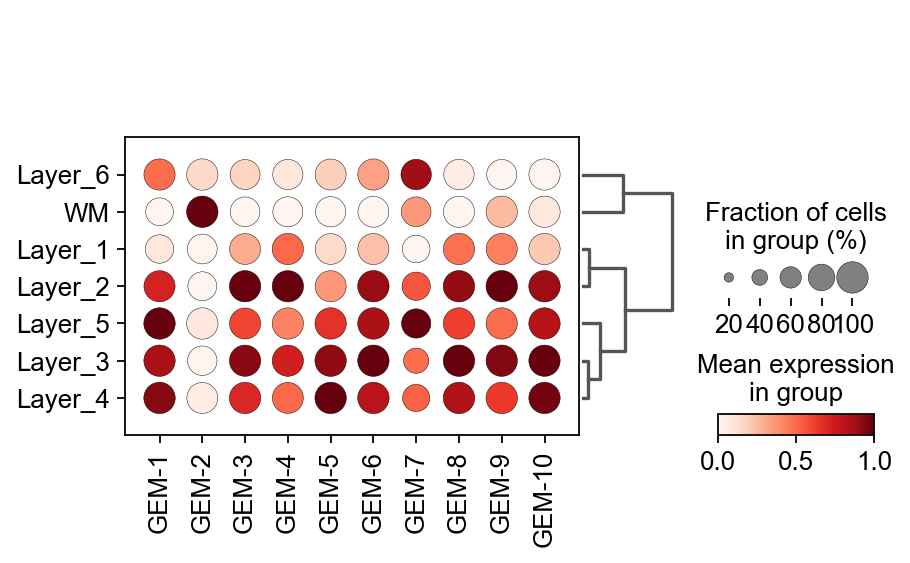

In [28]:
import matplotlib.pyplot as plt
ax=sc.pl.dotplot(adata_subset, adata_subset.var.index, groupby='Ground_Truth', 
              dendrogram=True,standard_scale='var',cmap='Reds',show=False)
color_dict=dict(zip(adata.obs['Ground_Truth'].cat.categories,adata.uns['Ground_Truth_colors']))

### Visualize the flowsig network

We fixed the network function provided by the author and provided a better visualization.

[Text(-0.2222222222222222, 0.03418803418803419, 'GEM-1'), Text(-1.5555555555555554, 0.03418803418803419, 'GEM-5'), Text(1.1111111111111112, 0.03418803418803419, 'GEM-2'), Text(0.6666666666666666, 0.03418803418803419, 'GEM-3'), Text(-2.0, 0.03418803418803419, 'GEM-4'), Text(2.0, 0.03418803418803419, 'GEM-7'), Text(-0.2222222222222222, -0.41025641025641024, 'SPP1'), Text(0.2222222222222222, -0.41025641025641024, 'CCK'), Text(0.0, 0.4786324786324786, 'inflow-FGF1')]


(<Figure size 640x320 with 1 Axes>, <Axes: >)

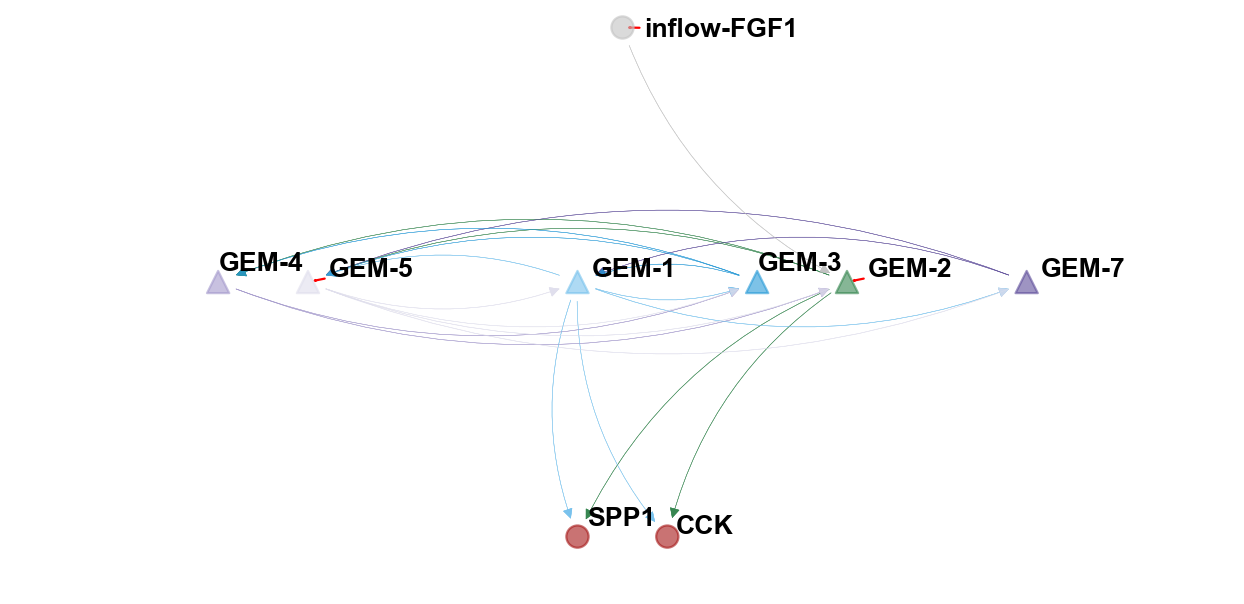

In [29]:
ov.pl.plot_flowsig_network(flow_network=flow_network,
                         gem_plot=['GEM-2','GEM-7','GEM-1','GEM-3','GEM-4','GEM-5'],
                        figsize=(8,4),
                     curve_awarg={'eps':2},
                      node_shape={'GEM':'^','Sender':'o','Receptor':'o'},
                          ylim=(-0.5,0.5),xlim=(-3,3))